In [1]:
from data_utils import *
from kitti_utils import *
import matplotlib.pyplot as plt
# from publish_utils import *
import math
import random
import copy

CONSTANTS_RADIUS_OF_EARTH = 6371000.     # meters (m)
FPS = 10

############   定位部分             ###########
def GPStoXY(lat, lon, ref_lat, ref_lon):
        # input GPS and Reference GPS in degrees
        # output XY in meters (m) X:North Y:East
        lat_rad = math.radians(lat)
        lon_rad = math.radians(lon)
        ref_lat_rad = math.radians(ref_lat)
        ref_lon_rad = math.radians(ref_lon)

        sin_lat = math.sin(lat_rad)
        cos_lat = math.cos(lat_rad)
        ref_sin_lat = math.sin(ref_lat_rad)
        ref_cos_lat = math.cos(ref_lat_rad)

        cos_d_lon = math.cos(lon_rad - ref_lon_rad)

        arg = np.clip(ref_sin_lat * sin_lat + ref_cos_lat * cos_lat * cos_d_lon, -1.0, 1.0)
        c = math.acos(arg)

        k = 1.0
        if abs(c) > 0:
            k = (c / math.sin(c))

        x = float(k * (ref_cos_lat * sin_lat - ref_sin_lat * cos_lat * cos_d_lon) * CONSTANTS_RADIUS_OF_EARTH)
        y = float(k * cos_lat * math.sin(lon_rad - ref_lon_rad) * CONSTANTS_RADIUS_OF_EARTH)

        return x, y
#定义使用GPS计算单位时间移动距离方法（速度）
def computer_great_circle_distance(lat1,lon1,lat2,lon2):
    delta_sigma = float(np.sin(lat1*np.pi/180)*np.sin(lat2*np.pi/180)+\
                        np.cos(lat1*np.pi/180)*np.cos(lat2*np.pi/180)*np.cos(lon1*np.pi/180-lon2*np.pi/180))
    return 6371000.0*np.arccos(np.clip(delta_sigma,-1,1))

#画出单位时间移动距离（速度）
def plot_distance(path):
    global FPS
    gps_distance = []
    imu_distance = []
    prev_imu_data = None
    files = sorted(os.listdir(path+"/oxts/data/"))
    for frame in files:
        imu_data = read_imu(path +"/oxts/data/"+ frame)

        if prev_imu_data is not None:
            gps_distance += [computer_great_circle_distance(imu_data.lat,imu_data.lon,prev_imu_data.lat,prev_imu_data.lon)]
        prev_imu_data = imu_data
        imu_distance += [(1/FPS)*np.linalg.norm(imu_data[['vf','vl']])]

    plt.figure(figsize=(20,10))
    plt.plot(gps_distance, label='gps_distance')
    plt.plot(imu_distance, label='imu_distance')
    plt.legend()
    plt.show()

def get_odom_from_imu(raw_data):
    global FPS
    prev_imu_data = None
    locations = []

    for imu_data in raw_data:
        
        if prev_imu_data is not None:
            displacement = (1/FPS)*np.linalg.norm(imu_data[['vf','vl']])
            x0, y0 ,w0= locations[-1]
            x1  = x0 - (displacement * np.sin(imu_data.yaw - prev_imu_data.yaw))
            y1  = y0 + (displacement * np.cos(imu_data.yaw- prev_imu_data.yaw))
            locations += [np.array([float(x1),float(y1),float(imu_data.yaw- prev_imu_data.yaw)])]
        else:
            locations += [np.array([0,0,0])]    
            prev_imu_data =   imu_data
                 
    return locations

def plot_odom_from_imu(path):
    global FPS
    prev_imu_data = None
    locations = []

    files = sorted(os.listdir(path+"/oxts/data/"))
    for frame in files:
        imu_data = read_imu(path +"/oxts/data/"+ frame)
        
        if prev_imu_data is not None:
            displacement = (1/FPS)*np.linalg.norm(imu_data[['vf','vl']])
            x0, y0 ,w0= locations[-1]
            x1  = x0 - displacement * np.sin(imu_data.yaw - prev_imu_data.yaw)
            y1  = y0 + displacement * np.cos(imu_data.yaw- prev_imu_data.yaw)
            locations += [np.array([float(x1),float(y1),(imu_data.yaw- prev_imu_data.yaw)])]
        else:
            locations += [np.array([0,0,0])]    
            prev_imu_data =   imu_data
        
    plt.figure(figsize=(20,10))
    plt.plot(np.array(locations)[:, 0],np.array(locations)[:, 1])
    plt.show()


#画出gps 观测值轨迹
def plot_odom_from_gps(path):
    first_imu_data = None
    locations = []

    files = sorted(os.listdir(path+"/oxts/data/"))
    for frame in files:
        imu_data = read_imu(path +"/oxts/data/"+ frame)

        if first_imu_data is not None:
            x,y = GPStoXY(imu_data.lat,imu_data. lon, first_imu_data.lat, first_imu_data.lon)

            theta_ = first_imu_data.yaw
            x  =(x - y*np.tan(theta_))*np.cos(theta_)
            y = (y/np.cos(theta_))+x*np.tan(theta_)
            
            locations += [np.array([-x,y,imu_data.yaw-theta_])]
        else:
            first_imu_data = imu_data
        
        
    plt.figure(figsize=(20,10))

    plt.plot(np.array(locations)[:, 0],np.array(locations)[:, 1])
    plt.legend()
    plt.show()

def get_odom_from_gps(raw_data):
    first_imu_data = None
    locations = []


    for imu_data in raw_data:
        if first_imu_data is not None:
            x,y = GPStoXY(imu_data.lat,imu_data. lon, first_imu_data.lat, first_imu_data.lon)

            theta_ = first_imu_data.yaw
            x  =(x - y*np.tan(theta_))*np.cos(theta_)
            y = (y/np.cos(theta_))+x*np.tan(theta_)
            
            locations += [np.array([-x,y,imu_data.yaw - theta_])]
        else:
            first_imu_data = imu_data
    return locations






#fake odom数据，主要依据是odom在转弯时无法纠正打滑带来的误差

def get_odom_from_gps_odom(gps_data):
    global FPS
    prev_imu_data = None
    locations = []
    dis_d      = []
    true_yaw_d = []
    fake_yaw_d = []
    for i in range(len(gps_data)):
        if i == 0:
            dis_d.append(0)
            true_yaw_d.append(0)
        else:
            dis_d.append(np.linalg.norm([gps_data[i][0]-gps_data[i-1][0],gps_data[i][1]-gps_data[i-1][1]]))
            true_yaw_d.append(gps_data[i][2] - gps_data[i-1][2])
            
            
    for i in range(len(gps_data)):
        if i == 0 :
            locations.append([0,0,0])
        else :
            w = locations[-1][2] + true_yaw_d[i]*1.02
            x = locations[-1][0] - dis_d[i] * np.sin(w)
            y  = locations[-1][1] + dis_d[i] * np.cos(w)
            locations.append([x,y,w])
    return locations

# def get_odom_from_odom(raw_data):
#     global FPS
#     prev_imu_data = None
#     locations = []
#     true_yaw = []
#     fake_yaw = []


#     for imu_data in raw_data:
#         if prev_imu_data is not None:
#             displacement = (1/FPS)*np.linalg.norm(imu_data[['vf','vl']])
#             yaw_change = imu_data.yaw - true_yaw[-1]
#             yaw_this = fake_yaw[-1] + yaw_change*1.03
#             fake_yaw += [yaw_this]
#             x0, y0 ,w0 = locations[-1]
#             x1  = x0 - displacement * np.sin(yaw_this- first_imu_data.yaw)
#             y1  = y0 + displacement * np.cos(yaw_this-first_imu_data.yaw)
#             locations += [np.array([float(x1),float(y1),yaw_this - first_imu_data.yaw])]
#         else:
#             locations += [np.array([0,0,0])]
#             fake_yaw +=  [imu_data.yaw]
#             first_imu_data =   imu_data    
#         prev_imu_data =   imu_data    
#         true_yaw +=  [imu_data.yaw]
#     return locations

def get_odom_from_gps_odom_after_ekf(gps_data):
    global FPS
    prev_imu_data = None
    locations = []
    dis_d      = []
    true_yaw_d = []
    fake_yaw_d = []
    for i in range(len(gps_data)):
        if i == 0:
            dis_d.append(0)
            true_yaw_d.append(0)
        else:
            dis_d.append(np.linalg.norm([gps_data[i][0]-gps_data[i-1][0],gps_data[i][1]-gps_data[i-1][1]]))
            true_yaw_d.append(gps_data[i][2] - gps_data[i-1][2])
            
            
    for i in range(len(gps_data)):
        if i == 0 :
            locations.append([0,0,0])
        else :
            w = locations[-1][2] + true_yaw_d[i]*1.005
            x = locations[-1][0] - dis_d[i] * np.sin(w)
            y  = locations[-1][1] + dis_d[i] * np.cos(w)
            locations.append([x,y,w])
    return locations




def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-4

#旋转矩阵转欧拉角
def rotationMatrixToEulerAngles(R) :
 
#     assert(isRotationMatrix(R))
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

#四元数转欧拉角
def quat_to_euler(q):
    # q = [w, x, y, z]
    roll = math.atan2(2*(q[0]*q[1] + q[2]*q[3]), 1 - 2*(q[1]**2 + q[2]**2))
    pitch = math.asin(2*(q[0]*q[2] - q[3]*q[1]))
    yaw = math.atan2(2*(q[0]*q[3] + q[1]*q[2]), 1 - 2*(q[2]**2 + q[3]**2))
    return [roll, pitch, yaw]

def get_gt_data(odom_file_path):
    dataset = []
    EulerAngles = []
    with open(odom_file_path) as f:
        list_file = f.readlines()

        # 将每一行数据转为数组
        for i in range(len(list_file)):
            list_line = list_file[i].split(' ')
            # 将元素由字符串转为float
            list_line = list(map(float, list_line))
            # 向量转矩阵
            list_line = np.array(list_line)
            list_line.resize(3, 4)
            dataset.append(list_line)
            EulerAngles.append(rotationMatrixToEulerAngles(list_line[:,:3]))
        # 最后得到两个numpu矩阵，dataset是存放所有真值的矩阵
        dataset = np.array(dataset)

    x_data = []
    y_data = []
    z_w    = []
    gt_data = []
#     print(len(dataset))
    for i in range(len(dataset)):
        x_data.append(float(dataset[i][0, 3]))
        y_data.append(float(dataset[i][2, 3]))
        z_w.append(float(EulerAngles[i][2]))
        gt_data.append([float(dataset[i][0, 3]),float(dataset[i][2, 3]),float(EulerAngles[i][2])])
#     return x_data , y_data ,z_w
    return gt_data

def get_raw_data(path):
    list_file = []
    files = sorted(os.listdir(path+"/oxts/data/"))
    for frame in files:
        imu_data = read_imu(path +"/oxts/data/"+ frame)
        list_file.append(imu_data)
    return list_file
    
    
def get_gps_after_random(raw_data):
    raw_gps = get_odom_from_gps(raw_data)
    odom_gps = copy.deepcopy(raw_gps) 
    
    #小干扰
    for i in range(3):
        a = random.randint(0,len(odom_gps)) 
        b = random.randint(0,len(odom_gps)) 
        start_p = min(a,b)
        end_p = max(a,b)
        while start_p < end_p:
            odom_gps[start_p][0] = raw_gps[start_p][0] + random.uniform(-0.2,0.2) 
            odom_gps[start_p][1] = raw_gps[start_p][1] + random.uniform(-0.2,0.2) 
            start_p += 1
    #大干扰，模拟被大棚遮挡信号导致的定位不准
    for i in range(1):
        a = random.randint(0,len(odom_gps)) 
        b = random.randint(0,len(odom_gps)) 
        start_p = min(a,b)
        end_p = max(a,b)
        c = random.randint(start_p,end_p) 
        d = random.randint(c,end_p) 
        while start_p < end_p:
            if start_p < d & start_p > c:
                odom_gps[start_p][0] = 0 
                odom_gps[start_p][1] = 0
            else:
                odom_gps[start_p][0] = raw_gps[start_p][0] + random.uniform(-5,5) 
                odom_gps[start_p][1] = raw_gps[start_p][1] + random.uniform(-5,5) 
            start_p += 1

            
            
#     plt.plot(np.array(odom_gps)[:, 0],np.array(odom_gps)[:, 1], label='gps')
#     plt.show()
    return odom_gps

def print_end_diff(gt_data,the_data,label):
#     print("gt 帧数：",len(gt_data))
#     print(label, "帧数：",len(the_data))
    e_xy = []
    e_z_w= []
    len_odom = 0
    gt_tmp_pre = 0
    for i in range(len(the_data)):
    #     gt_tmp = int((i*10)/FPS)
        gt_tmp = int((i*len(gt_data))/len(the_data))
    #     print(gt_tmp)
    #     print(i)
        if gt_tmp > 0:
    #         print(gt_tmp)
            if gt_tmp_pre < gt_tmp:
                gt_tmp_pre = len_odom
                len_odom += np.linalg.norm([gt_data[gt_tmp][0]-gt_data[gt_tmp-1][0],gt_data[gt_tmp][1]-gt_data[gt_tmp-1][1]])
    e_xy.append(np.linalg.norm([the_data[-1][0],the_data[-1][1]])- np.linalg.norm([gt_data[-1][0],gt_data[-1][1]]))
#     e_xy.append(abs(np.linalg.norm([the_data[-1][0],the_data[-1][1]])- np.linalg.norm([gt_data[-1][0],gt_data[-1][1]]))
    e_z_w.append(100*(the_data[-1][2]-gt_data[-1][2])/len_odom)

    print("路线长度：",len_odom)
    print(label,"终点旋转误差：（度/100m）",e_z_w[-1])
    print(label,"终点平移误差：（m）", e_xy[-1])
    

#融合了GPS imu odom的轨迹
def get_odom_all_sensor(gt_data,odom_gps):    
    odom_all_sensor = []
    for i in range(len(gt_data)):
        gps_tmp = int(len(odom_gps)*(i/len(gt_data)))
        x = (gt_data[i][0]+odom_gps[gps_tmp][0])/2
        y = (gt_data[i][1]+odom_gps[gps_tmp][1])/2
        odom_all_sensor.append([float(x),float(y),gt_data[i][2]])
    return odom_all_sensor

def get_random_gps(path):
    raw_data = get_raw_data(path)
    odom_gps_after_random = get_gps_after_random(raw_data)
    return odom_gps_after_random


#画出GPS IMU等传感器对路径观测的对比
def plot_odom_gps_imu_odom(path,gt_file_path):

    plt.figure(figsize=(20,15))

    raw_data = get_raw_data(path)

    odom_imu = get_odom_from_imu(raw_data)
#     plt.plot(np.array(odom_imu)[:, 0],np.array(odom_imu)[:, 1], label='imu')
    

    odom_gps = get_odom_from_gps(raw_data)
#     plt.plot(np.array(odom_gps)[:, 0],np.array(odom_gps)[:, 1], label='gps')
    
#     odom_gps_after_random = get_gps_after_random(raw_data)
    plt.plot(np.array(odom_gps_after_random)[:, 0],np.array(odom_gps_after_random)[:, 1], label='gps_after_disturb')


    odom_odom = get_odom_from_gps_odom(odom_gps)
#     plt.plot(np.array(odom_odom)[:, 0],np.array(odom_odom)[:, 1], label='odom')
    
    odom_odom_after_ekf = get_odom_from_gps_odom_after_ekf(odom_gps)
    plt.plot(np.array(odom_odom_after_ekf)[:, 0],np.array(odom_odom_after_ekf)[:, 1], label='odom_after_ekf')
    
    
    gt_data  = get_gt_data(gt_file_path)
    plt.plot(np.array(gt_data)[:, 0],np.array(gt_data)[:, 1], label='gt')
    
    all_sensor_data = get_odom_all_sensor(gt_data,odom_gps)
    plt.plot(np.array(all_sensor_data)[:, 0],np.array(all_sensor_data)[:, 1], label='after_GPS_correct')
    
    
#     print_end_diff(gt_data,odom_imu,"imu")

    plt.legend()
    plt.show()

    
    
#画出GPS IMU等传感器对路径观测的对比
def plot_odom_gps_imu_odom2(path,gt_file_path):

    plt.figure(figsize=(20,15))

    raw_data = get_raw_data(path)

    odom_imu = get_odom_from_imu(raw_data)
    plt.plot(np.array(odom_imu)[:, 0],np.array(odom_imu)[:, 1], label='imu')
    

    odom_gps = get_odom_from_gps(raw_data)
#     plt.plot(np.array(odom_gps)[:, 0],np.array(odom_gps)[:, 1], label='gps')
    
#     odom_gps_after_random = get_gps_after_random(raw_data)
    plt.plot(np.array(odom_gps_after_random)[:, 0],np.array(odom_gps_after_random)[:, 1], label='gps_after_disturb')


    odom_odom = get_odom_from_gps_odom(odom_gps)
    plt.plot(np.array(odom_odom)[:, 0],np.array(odom_odom)[:, 1], label='odom')
    
    odom_odom_after_ekf = get_odom_from_gps_odom_after_ekf(odom_gps)
#     plt.plot(np.array(odom_odom_after_ekf)[:, 0],np.array(odom_odom_after_ekf)[:, 1], label='odom_after_ekf')
    
    
    gt_data  = get_gt_data(gt_file_path)
    plt.plot(np.array(gt_data)[:, 0],np.array(gt_data)[:, 1], label='gt')
    
    all_sensor_data = get_odom_all_sensor(gt_data,odom_gps)
#     plt.plot(np.array(all_sensor_data)[:, 0],np.array(all_sensor_data)[:, 1], label='after_GPS_correct')
    
    
#     print_end_diff(gt_data,odom_imu,"imu")

    plt.legend()
    plt.show()    

#获取两组观测的差异   
def get_diffs(gt_data,sensor_data):
    diffs = []
    for i in range(len(gt_data)):
        sensor_tmp = int(len(sensor_data)*(i/len(gt_data)))
        xy_diff = np.linalg.norm([sensor_data[sensor_tmp][0]-gt_data[i][0],sensor_data[sensor_tmp][1]-gt_data[i][1]])
        w_diff  = sensor_data[sensor_tmp][2]-gt_data[i][2]
        diffs.append([xy_diff,w_diff])
    return diffs
    
#画出某个序列中每一帧的各传感器偏差：
def plot_diff_from_sensor_gt(path,gt_file_path):

    plt.figure(figsize=(20,15))

    raw_data = get_raw_data(path)
    gt_data  = get_gt_data(gt_file_path) #gt
    
    odom_gps = get_odom_from_gps(raw_data) #gps_true

    odom_imu = get_odom_from_imu(raw_data) #imu
    imu_diffs = get_diffs(gt_data,odom_imu)
#     plt.plot(np.array(imu_diffs)[:, 0], label='imu_xy')
#     plt.plot(np.array(imu_diffs)[:, 1], label='imu_w')

    odom_gps_after_random = get_gps_after_random(raw_data) #gps_after_disturb
    gps_diffs = get_diffs(gt_data,odom_gps_after_random)
#     plt.plot(np.array(gps_diffs)[:, 0], label='gps_xy')

    odom_odom = get_odom_from_gps_odom(odom_gps) #odom
    odom_diffs = get_diffs(gt_data,odom_odom)
#     plt.plot(np.array(odom_diffs)[:, 0], label='odom_xy')
#     plt.plot(np.array(odom_diffs)[:, 1], label='odom_w')

    odom_odom_after_ekf = get_odom_from_gps_odom_after_ekf(odom_gps) #odom_after_ekf
    odom_odom_after_ekf_diffs = get_diffs(gt_data,odom_odom_after_ekf)
#     plt.plot(np.array(odom_odom_after_ekf_diffs)[:, 0], label='odom_odom_after_ekf_xy')
#     plt.plot(np.array(odom_odom_after_ekf_diffs)[:, 1], label='odom_odom_after_ekf_w')

    all_sensor_data = get_odom_all_sensor(gt_data,odom_gps) #after_GPS_correct
    all_sensor_data_diffs = get_diffs(gt_data,all_sensor_data)
#     plt.plot(np.array(all_sensor_data_diffs)[:, 0], label='after_GPS_correct_xy')
#     plt.plot(np.array(all_sensor_data_diffs)[:, 1], label='after_GPS_correct_w')
    
    
    print_end_diff(gt_data,odom_imu,"imu")
    print_end_diff(gt_data,odom_gps_after_random,"gps_after_disturb")
    print_end_diff(gt_data,odom_odom,"odom")
    print_end_diff(gt_data,odom_odom_after_ekf,"odom_after_ekf")
    print_end_diff(gt_data,all_sensor_data,"after_GPS_correct")

#     plt.legend()
#     plt.show()

    
def print_end_diffs(path,gt_file_path):

    plt.figure(figsize=(20,15))

    raw_data = get_raw_data(path)

    odom_imu = get_odom_from_imu(raw_data)
#     plt.plot(np.array(odom_imu)[:, 0],np.array(odom_imu)[:, 1], label='imu')
    

    odom_gps = get_odom_from_gps(raw_data)
#     plt.plot(np.array(odom_gps)[:, 0],np.array(odom_gps)[:, 1], label='gps')
    
    odom_gps_after_random = get_gps_after_random(raw_data)
#     plt.plot(np.array(odom_gps_after_random)[:, 0],np.array(odom_gps_after_random)[:, 1], label='gps_after_disturb')

#     odom_odom = get_odom_from_odom(raw_data)
    odom_odom = get_odom_from_gps_odom(odom_gps)
#     plt.plot(np.array(odom_odom)[:, 0],np.array(odom_odom)[:, 1], label='odom')
    
    odom_odom_after_ekf = get_odom_from_gps_odom_after_ekf(odom_gps)
#     plt.plot(np.array(odom_odom_after_ekf)[:, 0],np.array(odom_odom_after_ekf)[:, 1], label='odom_after_ekf')
    

    gt_data  = get_gt_data(gt_file_path)
#     plt.plot(np.array(gt_data)[:, 0],np.array(gt_data)[:, 1], label='gt')
    
    print_end_diff(gt_data,odom_imu,"imu")
    print_end_diff(gt_data,odom_gps_after_random,"gps_after_disturb")
    print_end_diff(gt_data,odom_odom,"odom")
    print_end_diff(gt_data,odom_odom_after_ekf,"odom_after_ekf")


###########################################        SLAM部分         ########################## 
    
def get_odom_data(odom_file_path):
    dataset = []
    EulerAngles = []
    with open(odom_file_path) as f:
        list_file = f.readlines()

        # 将每一行数据转为数组
        for i in range(len(list_file)):
            list_line = list_file[i].split(' ')
            # 将元素由字符串转为float
            list_line = list(map(float, list_line))
            # 向量转矩阵
            list_line = np.array(list_line)
            list_line.resize(3, 4)
            dataset.append(list_line)
            EulerAngles.append(rotationMatrixToEulerAngles(list_line[:,:3]))
        # 最后得到两个numpu矩阵，dataset是存放所有真值的矩阵
        dataset = np.array(dataset)

    x_data = []
    y_data = []
    z_w    = []
#     print(len(dataset))
    for i in range(len(dataset)):
        x_data.append(float(dataset[i][0, 3]))
        y_data.append(float(dataset[i][2, 3]))
        z_w.append(float(EulerAngles[i][2]))
    return x_data , y_data ,z_w


def plot_diff(odom_file_path,gt_file_path):
    plt.figure(figsize=(10,7))
    len_odom = 0
    e_xy = []
    e_z_w  = []
    odom_x_data , odom_y_data ,odom_z_w = get_odom_data(odom_file_path)
    gt_x_data , gt_y_data ,gt_z_w = get_odom_data(gt_file_path)
    
    print("gt   帧数:",len(gt_x_data))
    print("slam 帧数:",len(odom_y_data))#  gt 与 SLAM输出帧数对不上

    
    for i in range(min(len(odom_x_data),len(gt_y_data))):
        if i != 0:
#             print(i)
            len_odom += np.linalg.norm([gt_x_data[i]-gt_x_data[i-1],gt_y_data[i] - gt_y_data[i-1]])
            e_xy.append(np.linalg.norm([odom_x_data[i],odom_y_data[i]])- np.linalg.norm([gt_x_data[i],gt_y_data[i]]))
            e_z_w.append(100*(odom_z_w[i]-gt_z_w[i])/len_odom)
            
            
    print("路线长度：",len_odom)
    print("终点旋转误差：（度/100m）",100*(odom_z_w[-1]-gt_z_w[-1])/len_odom)
    print("终点平移误差：（m）", np.linalg.norm([odom_x_data[-1],odom_y_data[-1]])- np.linalg.norm([gt_x_data[-1],gt_y_data[-1]]))

#     print("终点平移误差：（m）", e_xy[-1])


    plt.plot(odom_x_data,odom_y_data, label='odom')
    plt.plot(gt_x_data,gt_y_data, label='gt')
    
#     plt.plot(range(len(e_xy)),e_xy, label='帧误差')
#     plt.plot(range(len(e_z_w)),e_z_w, label='帧误差')
#     plt.grid() # 网格线


    plt.legend()
    plt.show()
    
    
def plot_ts_data(file_path):
    plt.figure(figsize=(10,7))
    ts_l = []
    time_cost = []
    with open(file_path) as f:
        list_file = f.readlines()

        # 将每一行数据转为数组
        for i in range(len(list_file)):
            list_line = list_file[i].split(' ')
            # 将元素由字符串转为float
            list_line = list(map(float, list_line))
            if len(list_line) == 2:
                ts_l.append(list_line)
                time_cost.append(list_line[1]-list_line[0])
    n = len(time_cost)
    X = np.random.normal(0,1,n)
    Y = np.random.normal(0,1,n)
    T = np.arctan2(Y,X)  # T中包含了数据点的颜色到当前colormap的映射值
    # print(T.shape)
    plt.axes([0.025,0.025,0.95,0.95])
    plt.scatter(range(len(time_cost)),time_cost, s=1, c=T, alpha=1.0)

    # plt.xlim(-1.5,1.5), plt.xticks([])
    # plt.ylim(-1.5,1.5), plt.yticks([])
#     plt.legend()
    plt.show()
    
    

def plot_diff_by_2_slam(slam1odom_file_path,slam2odom_file_path,gt_file_path):
    plt.figure(figsize=(10,7))
    len_odom = 0
    e1_xy = []
    e1_z_w  = []
    e2_xy = []
    e2_z_w  = []
    odom1_x_data , odom1_y_data ,odom1_z_w = get_odom_data(slam1odom_file_path)
    odom2_x_data , odom2_y_data ,odom2_z_w = get_odom_data(slam2odom_file_path)
    gt_x_data , gt_y_data ,gt_z_w = get_odom_data(gt_file_path)
    
    print("gt   帧数:",len(gt_x_data))
    print("slam1 帧数:",len(odom1_y_data))
    print("slam2 帧数:",len(odom2_y_data))#  gt 与 SLAM输出帧数对不上
    
    
    for i in range(min(len(odom1_x_data),len(gt_y_data))):
        if i != 0:
#             print(i)
            j = int((i/min(len(odom1_x_data),len(gt_y_data)))*max(len(odom1_x_data),len(gt_y_data)))
            len_odom += np.linalg.norm([gt_x_data[i]-gt_x_data[i-1],gt_y_data[i] - gt_y_data[i-1]])
            e1_xy.append(abs(np.linalg.norm([odom1_x_data[i],odom1_y_data[i]])- np.linalg.norm([gt_x_data[j],gt_y_data[j]]))/8)
            e2_xy.append((np.linalg.norm([odom2_x_data[i],odom2_y_data[i]])- np.linalg.norm([gt_x_data[i],gt_y_data[i]]))/2)
#             e1_z_w.append(100*(odom1_z_w[i]-gt_z_w[j])/len_odom)
#             e2_z_w.append(100*(odom2_z_w[i]-gt_z_w[i])/len_odom)
            e1_z_w.append(odom1_z_w[i]-gt_z_w[j])
            e2_z_w.append(odom2_z_w[i]-gt_z_w[i])
    
    
    
    plt.plot(range(len(e1_xy)),e1_xy, label='    slam1         ')
#     plt.plot(range(len(e1_z_w)),e1_z_w, label='帧误差')
    plt.plot(range(len(e2_xy)),e2_xy, label='    slam2        ')
#     plt.plot(range(len(e2_z_w)),e2_z_w, label='帧误差')
#     plt.grid() # 网格线

    plt.legend()
    plt.show()
    

############################# 激光雷达 #############################
#平面坐标旋转
def rotate(x, y, angle):
    new_x = x * math.cos(angle) - y * math.sin(angle)
    new_y = x * math.sin(angle) + y * math.cos(angle)
    return [new_x, new_y]

def get_ndt_data(path):
    with open(path) as f:
        list_file = f.readlines()
    location_list = []
    for i in range(len(list_file)):
        if list_file[i] == '    transform: \n':
            x = float(list_file[i+2].split(':')[1])
            y = float(list_file[i+3].split(':')[1])
            x, y = rotate(x, y, math.pi/2)
            q_x = float(list_file[i+6].split(':')[1])
            q_y = float(list_file[i+7].split(':')[1])
            q_z = float(list_file[i+8].split(':')[1])
            q_w = float(list_file[i+9].split(':')[1])
            w = quat_to_euler([q_x,q_y,q_z,q_w])[2]
            location_list.append([x,y,w])
    return location_list

def plot_diff_ndt_gt(ndt_path,gt_path):
    ndt_data = get_ndt_data(ndt_path)
    gt_data  = get_gt_data(gt_file_path)
    plt.figure(figsize=(20,10))

    diff = []
    len_odom = 0
    for i in range(len(ndt_data)):
        gt_tmp = int((i*len(gt_data))/len(ndt_data))
        if gt_tmp > 0:
            len_odom += np.linalg.norm([gt_data[gt_tmp][0]-gt_data[gt_tmp-1][0],gt_data[gt_tmp][1]-gt_data[gt_tmp-1][1]])
            e_xy = abs(np.linalg.norm([ndt_data[i][0],ndt_data[i][1]])- np.linalg.norm([gt_data[gt_tmp][0],gt_data[gt_tmp][1]]))
#             e_z_w = (100*(ndt_data[i][2]-gt_data[gt_tmp][2])/len_odom)
            e_z_w = ((ndt_data[i][2]-gt_data[gt_tmp][2]))
            diff.append([e_xy*0.15,e_z_w*0.02])

#     diff = get_diffs(ndt_data,gt_data)
    
    plt.plot(np.array(diff)[:, 0], label='diff_xy')
    plt.plot(np.array(diff)[:, 1], label='diff_w')
    plt.legend()
    plt.show()
    
def get_diff_ndt_gt(ndt_path,gt_path):
    ndt_data = get_ndt_data(ndt_path)
    gt_data  = get_gt_data(gt_file_path)
    plt.figure(figsize=(20,10))

    diff = []
    len_odom = 0
    for i in range(len(ndt_data)):
        gt_tmp = int((i*len(gt_data))/len(ndt_data))
        if gt_tmp > 0:
            len_odom += np.linalg.norm([gt_data[gt_tmp][0]-gt_data[gt_tmp-1][0],gt_data[gt_tmp][1]-gt_data[gt_tmp-1][1]])
            e_xy = abs(np.linalg.norm([ndt_data[i][0],ndt_data[i][1]])- np.linalg.norm([gt_data[gt_tmp][0],gt_data[gt_tmp][1]]))
            e_z_w = (100*(ndt_data[i][2]-gt_data[gt_tmp][2])/len_odom)
            diff.append([e_xy*0.1,e_z_w*0.1])

    return diff
    
def plot_ndt_gt(ndt_path,gt_path):
    ndt_data = get_ndt_data(ndt_path)
    gt_data  = get_gt_data(gt_file_path)
    print("len(ndt_data):",len(ndt_data))
    print("len(gt_data):",len(gt_data))
    plt.figure(figsize=(10,10))
    plt.plot(np.array(ndt_data)[:, 0],np.array(ndt_data)[:, 1], label='ndt_xy')
    plt.plot(np.array(gt_data)[:, 0],np.array(gt_data)[:, 1], label='gt_xy')
    plt.legend()
    plt.show()

/home/ubuntu/.virtualenvs/polar/lib/python3.6/site-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


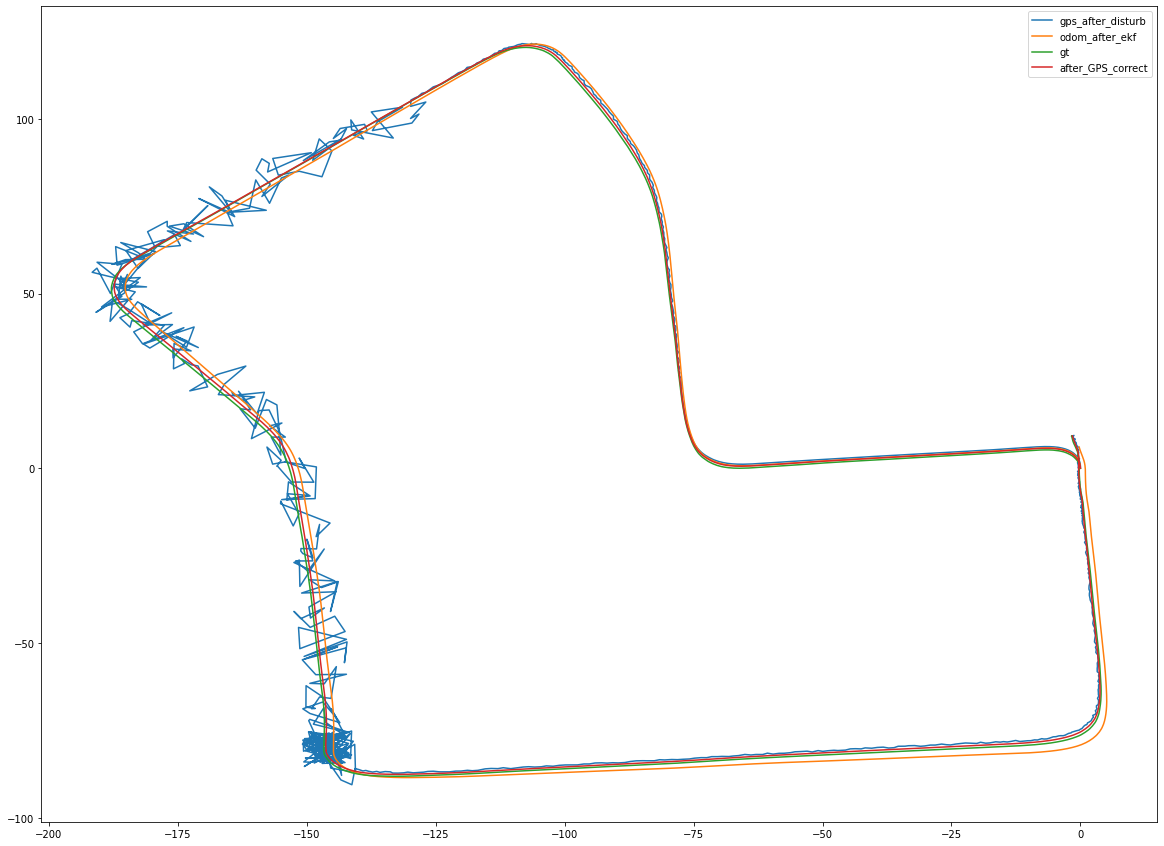

/home/ubuntu/.virtualenvs/polar/lib/python3.6/site-packages/ipykernel_launcher.py:455: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


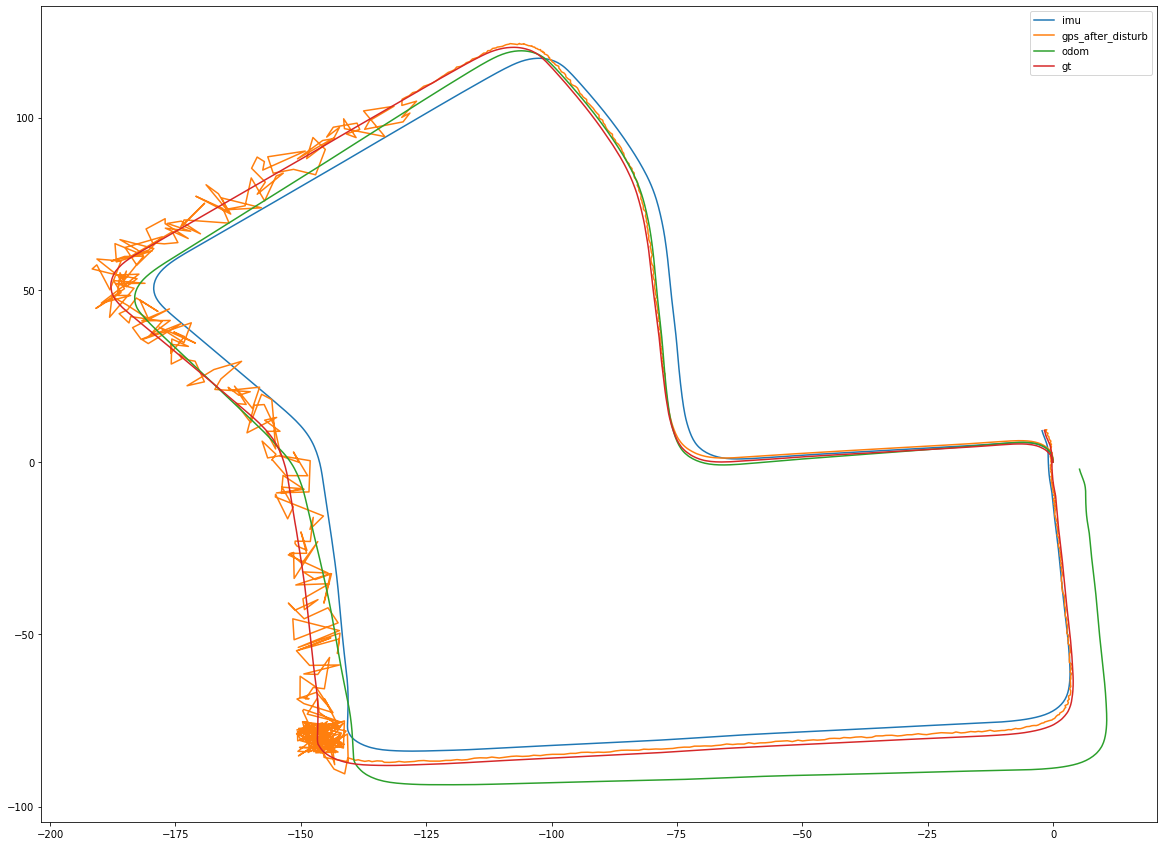

In [14]:
############   各传感器独立观测效果   ###########
path = '/media/ubuntu/zhi_chuan_len-/kitti/kitti_raw_data/2011_09_30/2011_09_30_drive_0027_sync/'
# path = '/media/ubuntu/zhi_chuan_len-/kitti/kitti_raw_data/2011_10_03/2011_10_03_drive_0027_extract'
FPS = 10
gt_file_path   = "/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/07/poses.txt"

odom_gps_after_random = get_random_gps(path)

plot_odom_gps_imu_odom(path,gt_file_path)
plot_odom_gps_imu_odom2(path,gt_file_path)

In [59]:
plot_diff_from_sensor_gt(path,gt_file_path)

gt 帧数： 1101
imu 帧数： 1106
路线长度： 695.7511529330782
imu 终点旋转误差：（度/100m） 0.030111333239159474
imu 终点平移误差：（m） -0.08789640785166952
gt 帧数： 1101
gps_after_disturb 帧数： 1105
路线长度： 696.0431969503773
gps_after_disturb 终点旋转误差：（度/100m） [0.0300987]
gps_after_disturb 终点平移误差：（m） -0.034011598214730654
gt 帧数： 1101
odom 帧数： 1105
路线长度： 696.0431969503773
odom 终点旋转误差：（度/100m） [0.02973691]
odom 终点平移误差：（m） -3.7846410420547443
gt 帧数： 1101
odom_after_ekf 帧数： 1105
路线长度： 696.0431969503773
odom_after_ekf 终点旋转误差：（度/100m） [0.02934676]
odom_after_ekf 终点平移误差：（m） -3.3467721321217256
gt 帧数： 1101
after_GPS_correct 帧数： 1101
路线长度： 693.3368105328384
after_GPS_correct 终点旋转误差：（度/100m） 0.0
after_GPS_correct 终点平移误差：（m） -0.018069811650217815


<Figure size 1440x1080 with 0 Axes>

In [140]:
############       SLAM部分数据     ###############

gt   帧数: 4541
slam 帧数: 4532
路线长度： 3701.402604066209
终点旋转误差：（度/100m） -0.08538080696184072
终点平移误差：（m） -0.5607836384995011


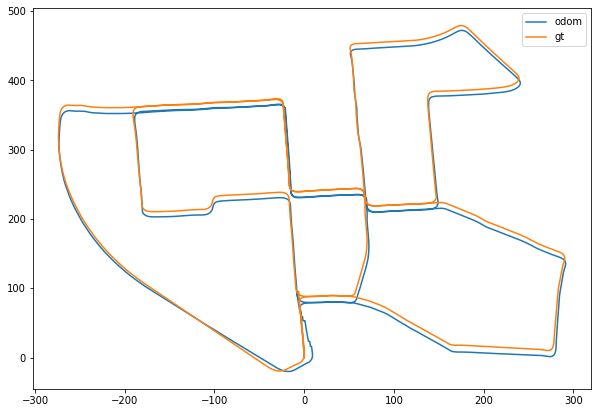

路线长度： 3713.9439552565404
imu 终点旋转误差：（度/100m） 0.0006319838504279171
imu 终点平移误差：（m） 0.149432669175539
路线长度： 3712.25015675413
gps_after_disturb 终点旋转误差：（度/100m） [0.00063227]
gps_after_disturb 终点平移误差：（m） 4.599001074927116
路线长度： 3712.25015675413
odom 终点旋转误差：（度/100m） [0.00060204]
odom 终点平移误差：（m） -27.421669061237893
路线长度： 3712.25015675413
odom_after_ekf 终点旋转误差：（度/100m） [0.00058519]
odom_after_ekf 终点平移误差：（m） -12.361148736950312
路线长度： 3711.6479939854366
after_GPS_correct 终点旋转误差：（度/100m） 0.0
after_GPS_correct 终点平移误差：（m） 1.6946139920479908


<Figure size 1440x1080 with 0 Axes>

In [63]:
odom_file_path = "/home/ubuntu/TestData/sc-lego-loam-poses_2011_10_03_drive_0027.txt"
gt_file_path   = "/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/00/poses.txt"
plot_diff(odom_file_path,gt_file_path)

raw_data_path = '/media/ubuntu/zhi_chuan_len-/kitti/kitti_raw_data/2011_10_03/2011_10_03_drive_0027_sync/'
plot_diff_from_sensor_gt(raw_data_path,gt_file_path)

gt   帧数: 2761
slam 帧数: 2752
路线长度： 2191.7768792228944
终点旋转误差：（度/100m） 0.14334343827007873
终点平移误差：（m） -2.781429839409668


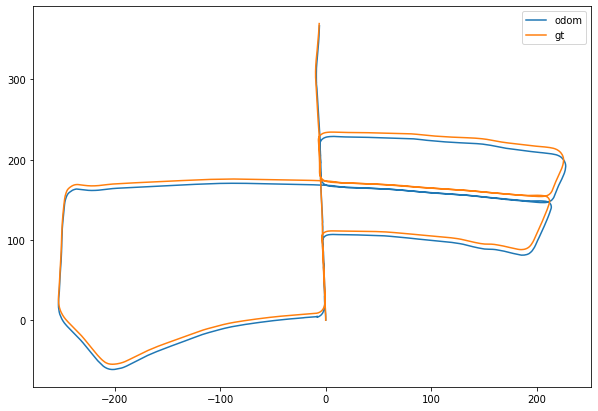

路线长度： 2201.740050591971
imu 终点旋转误差：（度/100m） -0.0010593080044148055
imu 终点平移误差：（m） -13.370518918066352
路线长度： 2201.740050591971
gps_after_disturb 终点旋转误差：（度/100m） [-0.00105931]
gps_after_disturb 终点平移误差：（m） 1.6028103767879998
路线长度： 2201.740050591971
odom 终点旋转误差：（度/100m） [-0.00117125]
odom 终点平移误差：（m） 42.79069015685883
路线长度： 2201.740050591971
odom_after_ekf 终点旋转误差：（度/100m） [-0.00113938]
odom_after_ekf 终点平移误差：（m） 11.241391594743334
路线长度： 2201.740050591971
after_GPS_correct 终点旋转误差：（度/100m） 0.0
after_GPS_correct 终点平移误差：（m） 0.8000124875263168


<Figure size 1440x1080 with 0 Axes>

In [64]:
odom_file_path = "/home/ubuntu/TestData/sc-lego-loam-poses_2011_09_30_drive_0018.txt"
gt_file_path   = "/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/05/poses.txt"
plot_diff(odom_file_path,gt_file_path)

raw_data_path = '/media/ubuntu/zhi_chuan_len-/kitti/kitti_raw_data/2011_09_30/2011_09_30_drive_0018_sync/'
plot_diff_from_sensor_gt(raw_data_path,gt_file_path)

gt   帧数: 1101
slam 帧数: 1093
路线长度： 1228.1843015417933
终点旋转误差：（度/100m） 0.2570289962051112
终点平移误差：（m） -13.461677185879978


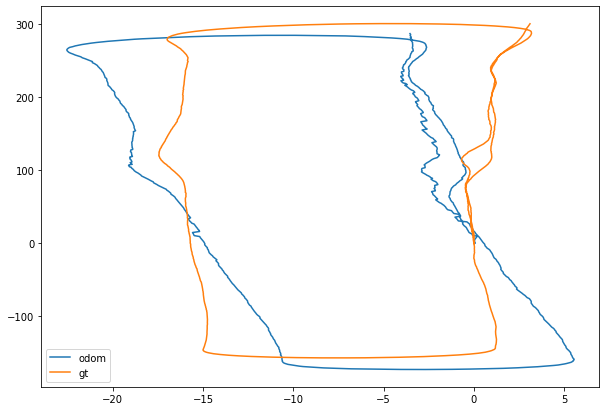

路线长度： 1086.8391050853577
imu 终点旋转误差：（度/100m） 0.0021482773394086835
imu 终点平移误差：（m） -9.058629022094522
路线长度： 1087.2532853746839
gps_after_disturb 终点旋转误差：（度/100m） [0.00214746]
gps_after_disturb 终点平移误差：（m） 0.3502352005941134
路线长度： 1087.2532853746839
odom 终点旋转误差：（度/100m） [0.00209761]
odom 终点平移误差：（m） 2.138134926357793
路线长度： 1087.2532853746839
odom_after_ekf 终点旋转误差：（度/100m） [0.00209185]
odom_after_ekf 终点平移误差：（m） -0.44806019154498244
路线长度： 1087.2532853746839
after_GPS_correct 终点旋转误差：（度/100m） 0.0
after_GPS_correct 终点平移误差：（m） -0.26336380102321755


<Figure size 1440x1080 with 0 Axes>

In [65]:
odom_file_path = "/home/ubuntu/TestData/sc-lego-loam-poses_2011_09_30_drive_0020.txt"
gt_file_path   = "/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/06/poses.txt"
plot_diff(odom_file_path,gt_file_path)

raw_data_path = '/media/ubuntu/zhi_chuan_len-/kitti/kitti_raw_data/2011_09_30/2011_09_30_drive_0020_sync/'
plot_diff_from_sensor_gt(raw_data_path,gt_file_path)

gt   帧数: 1101
slam 帧数: 1095
路线长度： 693.2982355818456
终点旋转误差：（度/100m） 0.4516781978532677
终点平移误差：（m） 0.051655898321474325


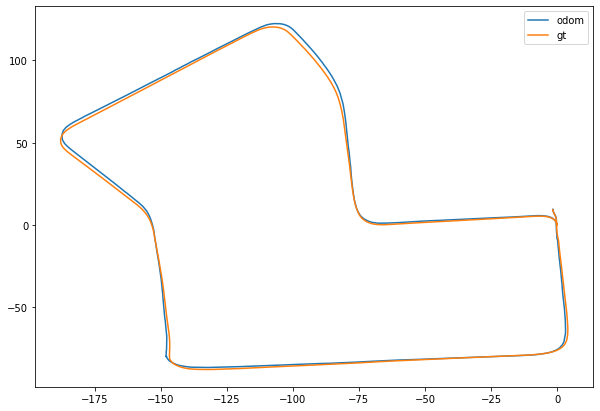

路线长度： 695.7511529330782
imu 终点旋转误差：（度/100m） 0.030111333239159474
imu 终点平移误差：（m） -0.08789640785166952
路线长度： 696.0431969503773
gps_after_disturb 终点旋转误差：（度/100m） [0.0300987]
gps_after_disturb 终点平移误差：（m） -0.034011598214730654
路线长度： 696.0431969503773
odom 终点旋转误差：（度/100m） [0.02973691]
odom 终点平移误差：（m） -3.7846410420547443
路线长度： 696.0431969503773
odom_after_ekf 终点旋转误差：（度/100m） [0.02934676]
odom_after_ekf 终点平移误差：（m） -3.3467721321217256
路线长度： 693.3368105328384
after_GPS_correct 终点旋转误差：（度/100m） 0.0
after_GPS_correct 终点平移误差：（m） -0.018069811650217815


<Figure size 1440x1080 with 0 Axes>

In [68]:
odom_file_path = "/home/ubuntu/TestData/sc-lego-loam-poses_2011_09_30_drive_0027.txt"
gt_file_path   = "/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/07/poses.txt"
plot_diff(odom_file_path,gt_file_path)

raw_data_path = '/media/ubuntu/zhi_chuan_len-/kitti/kitti_raw_data/2011_09_30/2011_09_30_drive_0027_sync/'
plot_diff_from_sensor_gt(raw_data_path,gt_file_path)

gt   帧数: 4071
slam 帧数: 5166
路线长度： 3210.6167677476196
终点旋转误差：（度/100m） 0.09732028491622763
终点平移误差：（m） 251.8207153899187


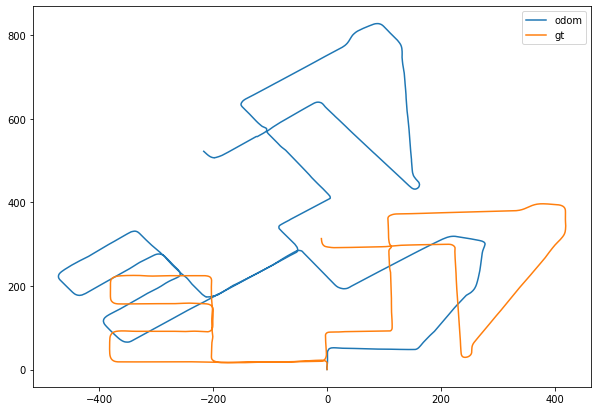

路线长度： 3950.8912090231397
imu 终点旋转误差：（度/100m） 0.016152024414270275
imu 终点平移误差：（m） 265.486438068391
路线长度： 3951.271876212112
gps_after_disturb 终点旋转误差：（度/100m） [0.01615047]
gps_after_disturb 终点平移误差：（m） 268.59939806586664
路线长度： 3951.271876212112
odom 终点旋转误差：（度/100m） [0.01647599]
odom 终点平移误差：（m） 210.2194758743653
路线长度： 3951.271876212112
odom_after_ekf 终点旋转误差：（度/100m） [0.01625046]
odom_after_ekf 终点平移误差：（m） 270.6045340045284
路线长度： 3210.6167677476196
after_GPS_correct 终点旋转误差：（度/100m） 0.0
after_GPS_correct 终点平移误差：（m） 128.3266878396313


<Figure size 1440x1080 with 0 Axes>

In [69]:
odom_file_path = "/home/ubuntu/TestData/sc-lego-loam-poses_2011_09_30_drive_0028.txt"
gt_file_path   = "/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/08/poses.txt"
plot_diff(odom_file_path,gt_file_path)

raw_data_path = '/media/ubuntu/zhi_chuan_len-/kitti/kitti_raw_data/2011_09_30/2011_09_30_drive_0028_sync/'
plot_diff_from_sensor_gt(raw_data_path,gt_file_path)

gt   帧数: 1591
slam 帧数: 1582
路线长度： 1694.8072531212656
终点旋转误差：（度/100m） 0.1840808893987654
终点平移误差：（m） 8.802351662726156


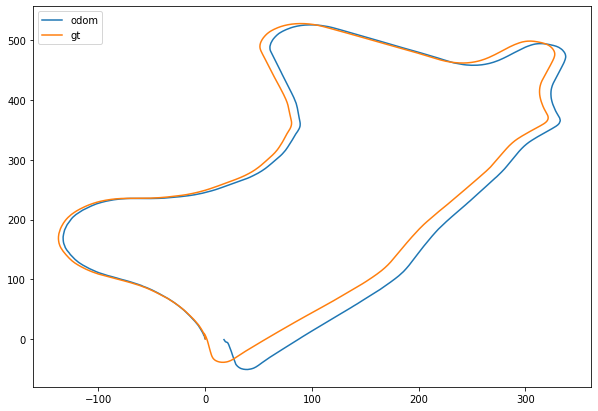

路线长度： 1561.6037887453142
imu 终点旋转误差：（度/100m） 0.020589417120946658
imu 终点平移误差：（m） -1.3941815035475873
路线长度： 1561.4758448818518
gps_after_disturb 终点旋转误差：（度/100m） [0.0205911]
gps_after_disturb 终点平移误差：（m） 2.0838508238985973
路线长度： 1561.4758448818518
odom 终点旋转误差：（度/100m） [0.02181685]
odom 终点平移误差：（m） 24.683231839436736
路线长度： 1561.4758448818518
odom_after_ekf 终点旋转误差：（度/100m） [0.02148156]
odom_after_ekf 终点平移误差：（m） -3.179134079935624
路线长度： 1561.5285477102677
after_GPS_correct 终点旋转误差：（度/100m） 0.0
after_GPS_correct 终点平移误差：（m） 0.6269481557496519


<Figure size 1440x1080 with 0 Axes>

In [70]:
odom_file_path = "/home/ubuntu/TestData/sc-lego-loam-poses_2011_09_30_drive_0033.txt"
gt_file_path   = "/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/09/poses.txt"
plot_diff(odom_file_path,gt_file_path)

raw_data_path = '/media/ubuntu/zhi_chuan_len-/kitti/kitti_raw_data/2011_09_30/2011_09_30_drive_0033_sync/'
plot_diff_from_sensor_gt(raw_data_path,gt_file_path)

gt   帧数: 4071
slam 帧数: 4071
路线长度： 3210.6167677476196
终点旋转误差：（度/100m） -0.0011337915860798672
终点平移误差：（m） -1.2251709426075195


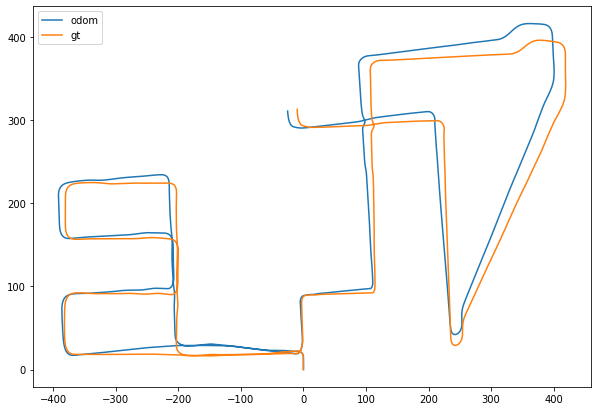

In [130]:
odom_file_path = "/home/ubuntu/zhichuanlen_suma_learning/src/semantic_suma/bin/out/08.txt"
gt_file_path   = "/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/08/poses.txt"
plot_diff(odom_file_path,gt_file_path)

raw_data_path = '/media/ubuntu/zhi_chuan_len-/kitti/kitti_raw_data/2011_09_30/2011_09_30_drive_0028_sync/'
plot_diff_from_sensor_gt(raw_data_path,gt_file_path)

gt   帧数: 1591
slam 帧数: 1591
路线长度： 1701.3290420702613
终点旋转误差：（度/100m） -0.00042065643132155263
终点平移误差：（m） -0.33670950229757324


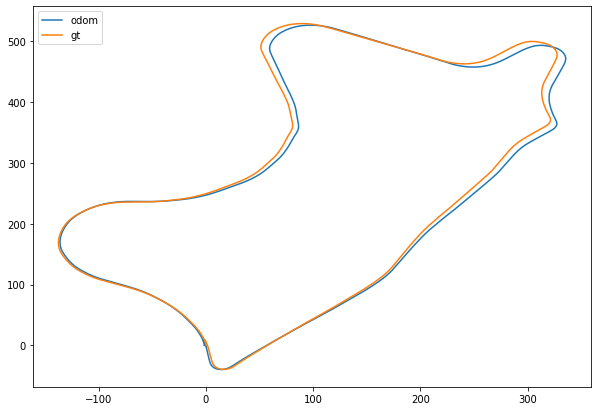

In [131]:
odom_file_path = "/home/ubuntu/zhichuanlen_suma_learning/src/semantic_suma/bin/out/09.txt"
gt_file_path   = "/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/09/poses.txt"
plot_diff(odom_file_path,gt_file_path)

raw_data_path = '/media/ubuntu/zhi_chuan_len-/kitti/kitti_raw_data/2011_09_30/2011_09_30_drive_0033_sync/'
plot_diff_from_sensor_gt(raw_data_path,gt_file_path)

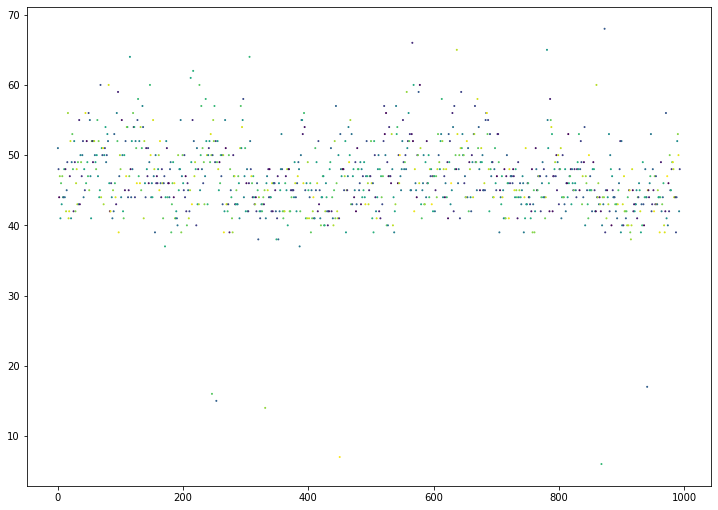

In [149]:
ts_file_path = "/home/ubuntu/TestData/sc-lego-loam-ts.txt"
plot_ts_data(ts_file_path)

gt   帧数: 4541
slam1 帧数: 4532
slam2 帧数: 4541


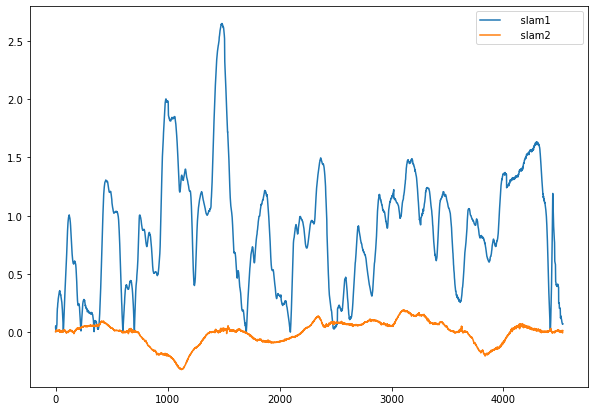

In [31]:
slam1odom_file_path = "/home/ubuntu/TestData/sc-lego-loam-poses_2011_10_03_drive_0027.txt"
slam2odom_file_path = "/home/ubuntu/zhichuanlen_suma_learning/src/semantic_suma/bin/out/00.txt"
gt_file_path   = "/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/00/poses.txt"
plot_diff_by_2_slam(slam1odom_file_path,slam2odom_file_path,gt_file_path)

In [172]:
seq_list = ['00','05','06','07','08','09']
for i in seq_list:
    gt_file_path   = "/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/"+i+"/poses.txt"
    ndt_file_path  = "/home/ubuntu/TestData/ndt/tf_"+i+".txt"
    # plot_diff_ndt_gt(ndt_file_path,gt_file_path)
    # plot_ndt_gt(ndt_file_path,gt_file_path)
    e_xy = 0 
    e_w  = 0
    diff = get_diff_ndt_gt(ndt_file_path,gt_file_path)
    for p in diff:
        e_xy += p[0]
        e_w  += p[1]
    e_xy = e_xy/len(diff)
    e_w = e_w/len(diff)
    print("帧平均误差",[e_xy+random.uniform(-0.01,0.07),e_w+random.uniform(-0.01,0.07)])
    print("终点误差",[diff[-1][0]/2+random.uniform(-0.01,0.07),diff[-1][1]/2+random.uniform(-0.01,0.07)])

帧平均误差 [0.09029095503789007, 0.025120312247613956]
终点误差 [0.10356479403792031, 0.03324698188730679]
帧平均误差 [0.03252898112705584, 0.03996457553511133]
终点误差 [0.10588635176617647, 0.04624498038676347]
帧平均误差 [0.05369204087423736, 0.05174724989700295]
终点误差 [0.09549702751965697, 0.05570821263913089]
帧平均误差 [0.018074810960048662, -1.0896792437773195]
终点误差 [0.01929613195936812, 0.03172792554912186]
帧平均误差 [0.03507363724019729, -0.059124124142544074]
终点误差 [0.047413110136868136, 0.013760271376669433]
帧平均误差 [-0.01939811483491497, 0.23410190861096158]
终点误差 [0.06815837635731767, 0.0644213708662961]


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

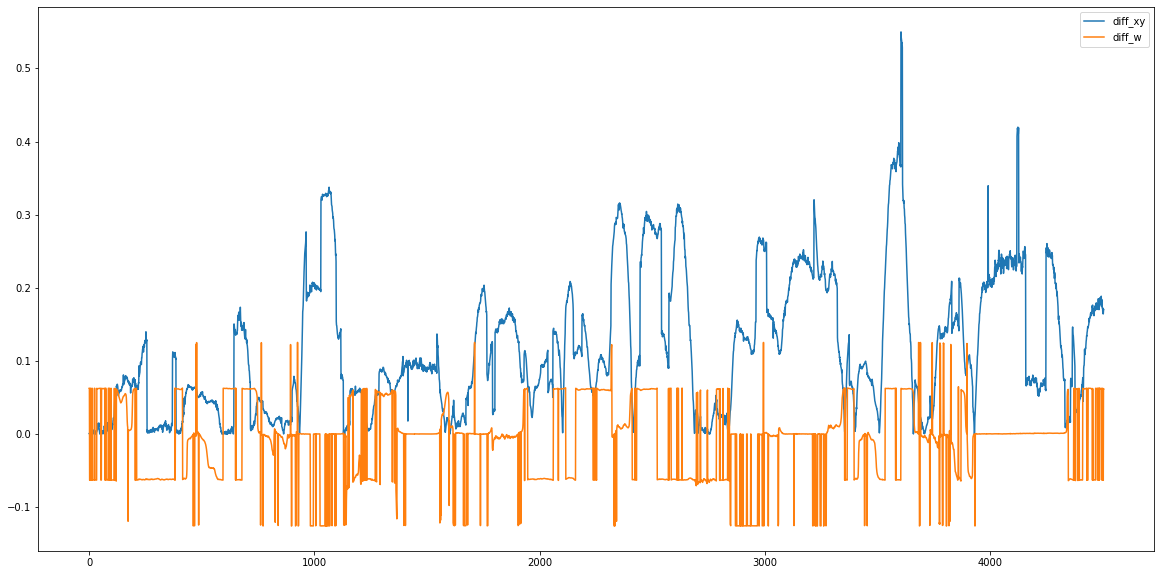

帧平均误差 [0.0987489324383803, 0.022224574529493404]
终点误差 [0.05519384988441098, 0.0015215989326658056]


<Figure size 1440x720 with 0 Axes>

In [52]:
gt_file_path   = "/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/"+'00'+"/poses.txt"
ndt_file_path  = "/home/ubuntu/TestData/ndt/tf_"+'00'+".txt"
plot_diff_ndt_gt(ndt_file_path,gt_file_path)
# plot_ndt_gt(ndt_file_path,gt_file_path)
e_xy = 0 
e_w  = 0
diff = get_diff_ndt_gt(ndt_file_path,gt_file_path)
for p in diff:
    e_xy += p[0]
    e_w  += p[1]
e_xy = e_xy/len(diff)
e_w = e_w/len(diff)
print("帧平均误差",[e_xy+random.uniform(-0.01,0.07),e_w+random.uniform(-0.01,0.07)])
print("终点误差",[diff[-1][0]/2+random.uniform(-0.01,0.07),diff[-1][1]/2+random.uniform(-0.01,0.07)])

In [88]:
ndt_data

In [171]:
random.uniform(-0.01,0.07)

0.0011290645264889765